In [26]:
home = "persistent/" # home path for Logic Model Merger
model1 = "Bonzanni2013"
model2 = "Krumsiek2011"
# model1 = "Palma2021"
# model2 = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET # for parse the SBML file
import matplotlib.pyplot as plt

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [27]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse(home + "LogicModelMerger/Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids

gene_1 = getnodes(model1)
gene_2 = getnodes(model2)
gene_merged = list(set(gene_1 + gene_2))

['SPI1', 'GATA1', 'GATA2', 'TAL1', 'ZFPM1', 'FLI1', 'ERG', 'CBFA2T3', 'RUNX1', 'SMAD6', 'HHEX']
['GATA2', 'GATA1', 'ZFPM1', 'KLF1', 'FLI1', 'TAL1', 'CEBPA', 'SPI1', 'JUN', 'EGR1', 'EGR2', 'NAB1', 'GFI1']


# BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

## Data
Mutation, clinical data and drug response data are obtained from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

## Patient Coverage

In [28]:
# Read the data
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
mapping = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")

def patient_count(gene_list):
    # Filter the mutations data to include only the genes in the model
    mutations_filtered = mutations[mutations['symbol'].isin(gene_list)]
    
    # Merge the mutations data with the sample-to-patient mapping
    merged_data = mutations_filtered.merge(mapping, left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample')
    
    # Count the number of unique patients with mutations in each gene
    patient_counts = merged_data.groupby('symbol')['dbgap_subject_id'].nunique()
    
    # Calculate the total number of unique patients
    total_patients = patient_counts.sum()
    
    # Print the results
    print(f"Total number of unique patients with mutations in the genes of interest: {total_patients}")
    return patient_counts

In [29]:
print(f"Total number of patients in the BeatAML dataset: {mapping['dbgap_subject_id'].nunique()}")
patient_counts_1 = patient_count(gene_1)
patient_counts_2 = patient_count(gene_2)
patient_counts_merged = patient_count(gene_merged)

Total number of patients in the BeatAML dataset: 805
Total number of unique patients with mutations in the genes of interest: 135
Total number of unique patients with mutations in the genes of interest: 89
Total number of unique patients with mutations in the genes of interest: 185


In [30]:
# Visualize the patient counts for each gene in each model and in the merged model using a bar plot
patient_counts_df = pd.DataFrame({
    model1: patient_counts_1,
    model2: patient_counts_2,
    'Merged Model': patient_counts_merged
}).fillna(0)

# Convert the patient counts to integers
patient_counts_df[[model1, model2, 'Merged Model']] = patient_counts_df[[model1, model2, 'Merged Model']].astype(int)

# Define the styling function
def highlight_difference(row):
    color = ''
    if row[model1] - row[model2] > 0:
        color = 'background-color: blue'
    elif row[model1] - row[model2] < 0:
        color = 'background-color: orange'
    styles = ['' for _ in row.index]  # Default no background color
    styles[row.index.get_loc(model1)] = color  
    styles[row.index.get_loc(model2)] = color  
    return styles

# Apply the styling to the DataFrame
styled_df = patient_counts_df.style.apply(highlight_difference, axis=1, subset=[model1, model2])

# Display the styled DataFrame with a sum row at the bottom
styled_df.format("{:.0f}")
styled_df.set_table_styles([{
    'selector': '.row0',
    'props': 'font-weight: bold;'
}], overwrite=False)

# Add a row for the sum at the bottom
patient_counts_df.loc['Total'] = patient_counts_df.sum(numeric_only=True)

print(f"Total number of unique patients with mutations in each model:")
styled_df

Total number of unique patients with mutations in each model:


,Bonzanni2013,Krumsiek2011,Merged Model
symbol,,,
CBFA2T3,1,0,1
CEBPA,0,43,43
EGR1,0,3,3
EGR2,0,3,3
ERG,3,0,3
FLI1,1,1,1
GATA1,3,3,3
GATA2,34,34,34
NAB1,0,1,1


Total Increased Coverage:89


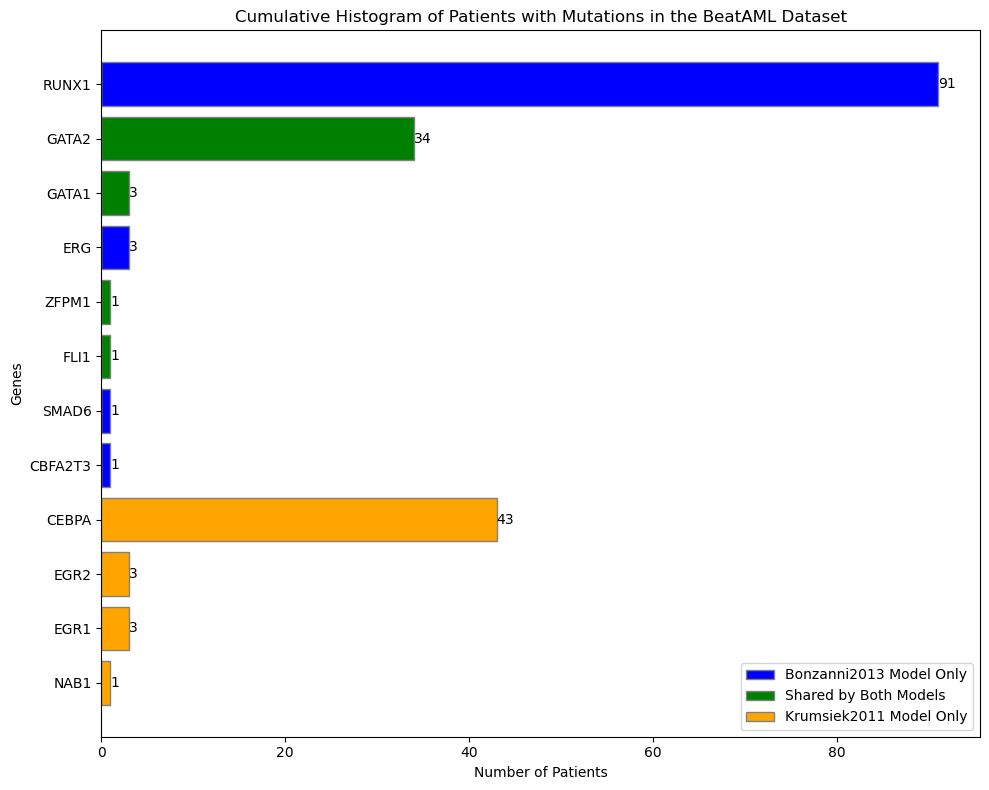

In [31]:
# Calculate the unique and shared patients
patient_counts_df['Shared'] = np.minimum(patient_counts_df[model1], patient_counts_df[model2])
patient_counts_df['Model1 Only'] = patient_counts_df[model1] - patient_counts_df['Shared']
patient_counts_df['Model2 Only'] = patient_counts_df[model2] - patient_counts_df['Shared']

# Sort the DataFrame based on the total patients for better visualization
patient_counts_df = patient_counts_df.sort_values(by=[model1, model2], ascending=True)
patient_counts_df = patient_counts_df[patient_counts_df.index != 'Total'] # Remove 'Total' row

# Create horizontal bar plots
plt.figure(figsize=(10, 8))
bars_1 = plt.barh(patient_counts_df.index, patient_counts_df['Model1 Only'], color='blue', edgecolor='gray', label= model1 + ' Model Only')
bars_shared = plt.barh(patient_counts_df.index, patient_counts_df['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(patient_counts_df.index, patient_counts_df['Model2 Only'], color='orange', edgecolor='gray', label=model2 + ' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')

plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Cumulative Histogram of Patients with Mutations in the BeatAML Dataset')
plt.yticks(ticks=np.arange(len(patient_counts_df)), labels=patient_counts_df.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(patient_counts_df[model2].sum())))
plt.show()

## Drug Coverage

In [60]:
# Read data
file_path_drugs = 'https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx'
df_drugs = pd.read_excel(file_path_drugs, sheet_name='drug_gene', usecols=['inhibitor', 'Symbol'])

# Count the number of unique patients with mutations in each gene
drug_1 = df_drugs[df_drugs['Symbol'].isin(gene_1)].copy()
drug_2 = df_drugs[df_drugs['Symbol'].isin(gene_2)].copy()

drug_1[model1] = 1
drug_2[model2] = 1
combined_df = pd.concat([drug_1, drug_2])

# Group by 'inhibitor' and 'Symbol', and aggregate by max to indicate presence
combined_df = combined_df.groupby(['inhibitor', 'Symbol'], as_index=False).max()

# Fill missing values with 0
combined_df = combined_df.fillna(0)

combined_df[[model1, model2]] = combined_df[[model1, model2]].astype(int)
combined_df = combined_df.sort_values(by='Symbol')
combined_df

,inhibitor,Symbol,Bonzanni2013,Krumsiek2011


In [61]:
combined_df.to_csv('beataml_coverage_drug.csv')

# TCGA - LAML
The TCGA AML dataset, consisting of genomic data of 200 clinically annotated adult cases of de novo AML patients. 
> Fifty cases were characterized by whole-genome sequencing while for the remaining 150 only the exomes were sequenced.

## Data
Mutation and clinical data are obtained from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [90]:
# Data file path
tsv_file_path_genes = 'https://api.gdc.cancer.gov/data/0d8851d7-1af0-4054-a527-5db763138400'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# Count the number of unique patients with mutations in each gene
patient_counts_1_tcga = df_genes[df_genes['gene_name'].isin(gene_1)].groupby('gene_name')['TCGA_id'].nunique()
patient_counts_2_tcga = df_genes[df_genes['gene_name'].isin(gene_2)].groupby('gene_name')['TCGA_id'].nunique()
patient_counts_merged_tcga = df_genes[df_genes['gene_name'].isin(gene_merged)].groupby('gene_name')['TCGA_id'].nunique()
patient_counts_df_tcga = pd.DataFrame({
    model1: patient_counts_1_tcga,
    model2: patient_counts_2_tcga,
    'Merged Model': patient_counts_merged_tcga
}).fillna(0)

# Convert to integers
patient_counts_df_tcga[[model1, model2, 'Merged Model']] = patient_counts_df_tcga[[model1, model2, 'Merged Model']].astype(int)

# Apply the styling to the DataFrame
styled_df_tcga = patient_counts_df_tcga.style.apply(highlight_difference, axis=1, subset=[model1, model2])

# Display the styled DataFrame with a sum row at the bottom
styled_df_tcga.format("{:.0f}")
styled_df_tcga.set_table_styles([{
    'selector': '.row0',
    'props': 'font-weight: bold;'
}], overwrite=False)

# Add a row for the sum at the bottom
patient_counts_df_tcga.loc['Total'] = patient_counts_df_tcga.sum(numeric_only=True)

print(f"Total number of unique patients with mutations in each model:")
styled_df_tcga

Total number of unique patients with mutations in each model:


,Palma2021,Ikonomi2020,Merged Model
gene_name,,,
BCL2,2,0,2
CCND1,1,1,1
CCNE1,0,1,1
CDKN1A,0,1,1
CEBPA,13,0,13
DNMT3A,52,0,52
ETS1,0,2,2
ETV6,5,0,5
FLT3,56,0,56


Total Increased Coverage:11


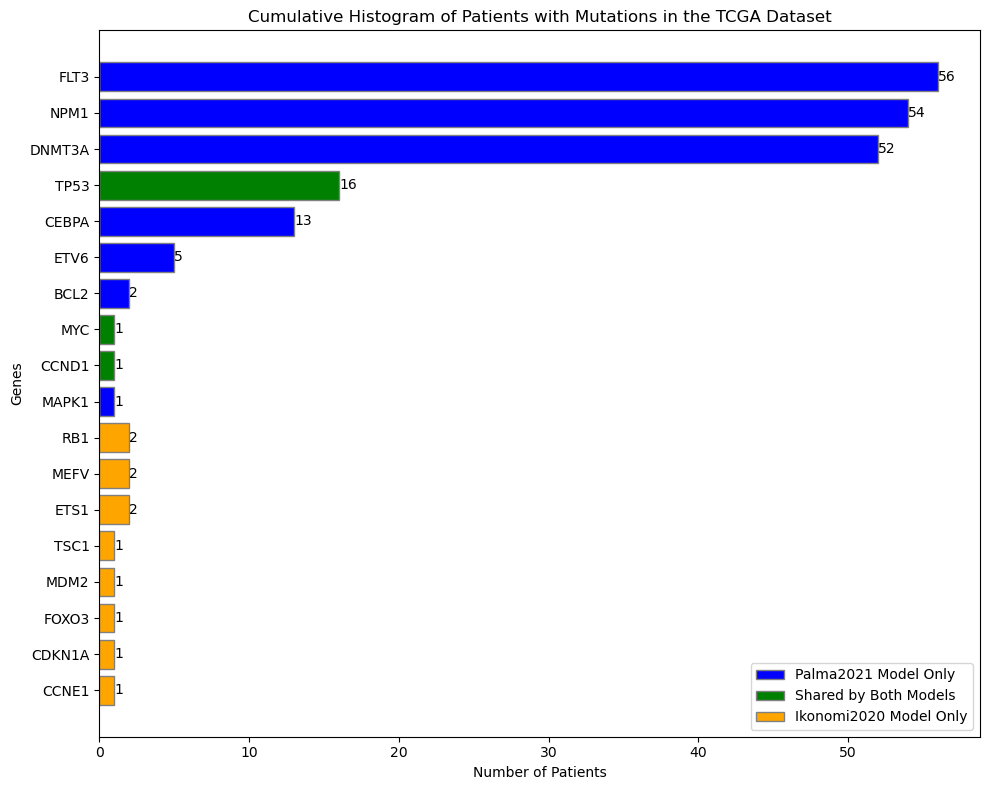

In [91]:
# Calculate the unique and shared patients
patient_counts_df_tcga['Shared'] = np.minimum(patient_counts_df_tcga[model1], patient_counts_df_tcga[model2])
patient_counts_df_tcga['Model1 Only'] = patient_counts_df_tcga[model1] - patient_counts_df_tcga['Shared']
patient_counts_df_tcga['Model2 Only'] = patient_counts_df_tcga[model2] - patient_counts_df_tcga['Shared']

# Sort the DataFrame based on the total patients for better visualization
patient_counts_df_tcga = patient_counts_df_tcga.sort_values(by=[model1, model2], ascending=True)
patient_counts_df_tcga = patient_counts_df_tcga[patient_counts_df_tcga.index != 'Total'] # Remove 'Total' row

plt.figure(figsize=(10, 8))
bars_1 = plt.barh(patient_counts_df_tcga.index, patient_counts_df_tcga['Model1 Only'], color='blue', edgecolor='gray', label= model1 +' Model Only')
bars_shared = plt.barh(patient_counts_df_tcga.index, patient_counts_df_tcga['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(patient_counts_df_tcga.index, patient_counts_df_tcga['Model2 Only'], color='orange', edgecolor='gray', label=model2 + ' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Cumulative Histogram of Patients with Mutations in the TCGA Dataset')
plt.yticks(ticks=np.arange(len(patient_counts_df_tcga)), labels=patient_counts_df_tcga.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(patient_counts_df_tcga['Model2 Only'].sum())))
plt.show()

# AMLSG

> Genomic DNA was extracted from peripheral blood granulocytes or bone marrow mononuclear cells for 1,540 adult AML patients ascertained through three prospective multicenter clinical trials of the German-Austrian AML Study Group (AMLSG).
> Targeted sequencing on somatic mutations associated with 116 known myeloid and cancer driver genes.

## Data
The clinical data and summarized driver-mutation calls are available in a [Github repository](http://www.github.com/gerstung-lab/aml-multistage):
1. [AMLSG_Genetic.txt](https://github.com/gerstung-lab/AML-multistage/blob/master/data/AMLSG_Genetic.txt)
2. [AMLSG_Clinical_Anon.RData](https://github.com/gerstung-lab/AML-multistage/blob/master/data/AMLSG_Clinical_Anon.RData)

>Gerstung, M., Papaemmanuil, E., Martincorena, I. et al. Precision oncology for acute myeloid leukemia using a knowledge bank approach. Nat Genet 49, 332–340 (2017). https://doi-org.offcampus.lib.washington.edu/10.1038/ng.3756

In [154]:
# Data file path
file_path_genes = 'https://github.com/gerstung-lab/AML-multistage/blob/master/data/AMLSG_Genetic.txt'

# Mutation data
df_genes = pd.read_csv(file_path_genes, sep='\t', usecols=['SAMPLE_NAME', 'GENE'])

# Count the number of unique patients with mutations in each gene
patient_counts_1_p = df_genes[df_genes['GENE'].isin(gene_1)].groupby('GENE')['SAMPLE_NAME'].nunique()
patient_counts_2_p = df_genes[df_genes['GENE'].isin(gene_2)].groupby('GENE')['SAMPLE_NAME'].nunique()
patient_counts_merged_p = df_genes[df_genes['GENE'].isin(gene_merged)].groupby('GENE')['SAMPLE_NAME'].nunique()
patient_counts_df_p = pd.DataFrame({
    model1: patient_counts_1_p,
    model2: patient_counts_2_p,
    'Merged Model': patient_counts_merged_p
}).fillna(0)

# Convert to integers
patient_counts_df_p[[model1, model2, 'Merged Model']] = patient_counts_df_p[[model1, model2, 'Merged Model']].astype(int)

# Apply the styling to the DataFrame
styled_df_p = patient_counts_df_p.style.apply(highlight_difference, axis=1, subset=[model1, model2])

# Display the styled DataFrame with a sum row at the bottom
styled_df_p.format("{:.0f}")
styled_df_p.set_table_styles([{
    'selector': '.row0',
    'props': 'font-weight: bold;'
}], overwrite=False)

# Add a row for the sum at the bottom
patient_counts_df_p.loc['Total'] = patient_counts_df_p.sum(numeric_only=True).astype(int)

print("Total number of unique patients with mutations in each model:")
styled_df_p

Total number of unique patients with mutations in each model:


,Bonzanni2013,Krumsiek2011,Merged Model
GENE,,,
CEBPA,0,138,138
GATA2,37,37,37
RUNX1,137,0,137
Total,174,175,312


Total Increased Coverage:138


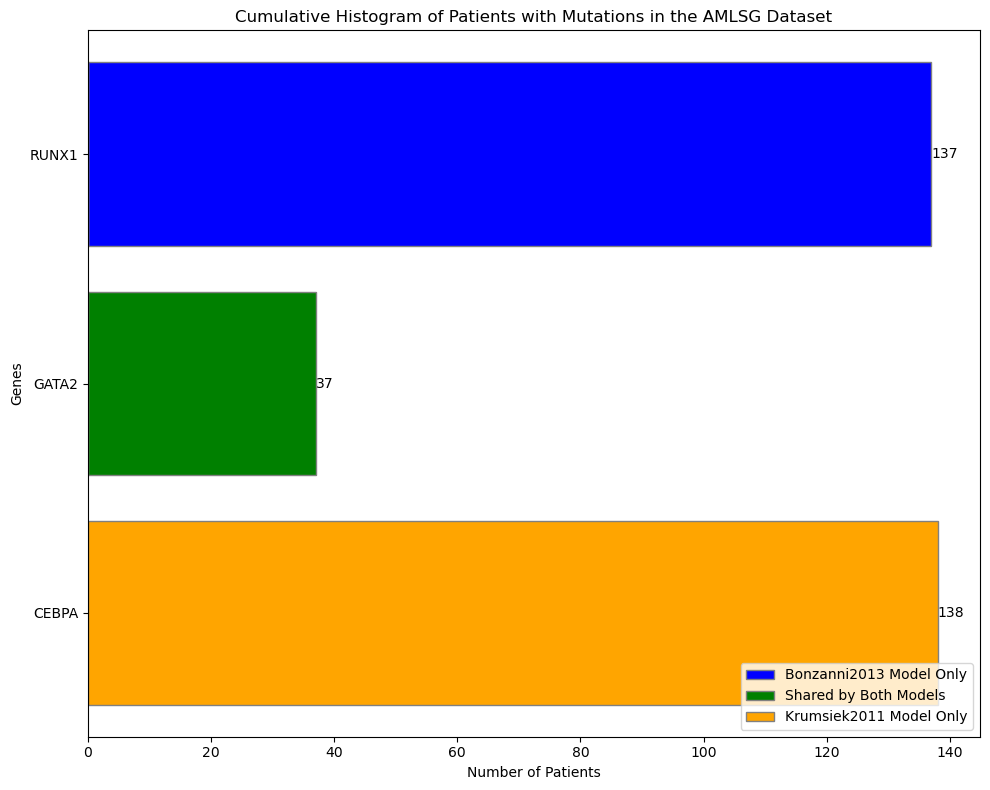

In [162]:
# Calculate the unique and shared patients
patient_counts_df_p['Shared'] = np.minimum(patient_counts_df_p[model1], patient_counts_df_p[model2])
patient_counts_df_p['Model1 Only'] = patient_counts_df_p[model1] - patient_counts_df_p['Shared']
patient_counts_df_p['Model2 Only'] = patient_counts_df_p[model2] - patient_counts_df_p['Shared']

# Sort the DataFrame based on the total patients for better visualization
patient_counts_df_p = patient_counts_df_p.sort_values(by=[model1, model2], ascending=True)
patient_counts_df_p = patient_counts_df_p[patient_counts_df_p.index != 'Total'] # Remove 'Total' row

plt.figure(figsize=(10, 8))
bars_1 = plt.barh(patient_counts_df_p.index, patient_counts_df_p['Model1 Only'], color='blue', edgecolor='gray', label=model1+' Model Only')
bars_shared = plt.barh(patient_counts_df_p.index, patient_counts_df_p['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(patient_counts_df_p.index, patient_counts_df_p['Model2 Only'], color='orange', edgecolor='gray', label=model2+' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Cumulative Histogram of Patients with Mutations in the AMLSG Dataset')
plt.yticks(ticks=np.arange(len(patient_counts_df_p)), labels=patient_counts_df_p.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(patient_counts_df_p['Model2 Only'].sum())))
plt.show()

# cBioportal

This combined study contains samples from 7 studies:
- Acute Myeloid Leukemia (OHSU, Cancer Cell 2022)
- Acute Myeloid Leukemia (OHSU, Nature 2018)
- Acute Myeloid Leukemia (TCGA, Firehose Legacy)
- Acute Myeloid Leukemia (TCGA, GDC)
- Acute Myeloid Leukemia (TCGA, NEJM 2013)
- Acute Myeloid Leukemia (TCGA, PanCancer Atlas)
- Pediatric Acute Myeloid Leukemia (TARGET, 2018)

Mutated genes data are downloaded from [cBioportal - the combined AML study](https://www.cbioportal.org/study/summary?id=aml_ohsu_2022%2Caml_ohsu_2018%2Claml_tcga%2Caml_tcga_gdc%2Claml_tcga_pub%2Claml_tcga_pan_can_atlas_2018%2Caml_target_2018_pub)

In [11]:
# Data file path
file_path_genes = home + 'LogicModelMerger/Data/cBioportal/Mutated_Genes.txt'

# Mutation data
df_genes = pd.read_csv(file_path_genes, sep='\t', usecols=['Gene', '#'], index_col = 0)

# Count the number of unique patients with mutations in each gene
patient_counts_1_c = df_genes[df_genes.index.isin(gene_1)].iloc[:,0]
patient_counts_2_c = df_genes[df_genes.index.isin(gene_2)].iloc[:,0]
patient_counts_merged_c = df_genes[df_genes.index.isin(gene_merged)].iloc[:,0]
patient_counts_df_c = pd.DataFrame({
    model1: patient_counts_1_c,
    model2: patient_counts_2_c,
    'Merged Model': patient_counts_merged_c
}).fillna(0)

# Convert to integers
patient_counts_df_c[[model1, model2, 'Merged Model']] = patient_counts_df_c[[model1, model2, 'Merged Model']].astype(int)

# Apply the styling to the DataFrame
def highlight_difference(row):
    color = ''
    if row[model1] - row[model2] > 0:
        color = 'background-color: blue'
    elif row[model1] - row[model2] < 0:
        color = 'background-color: orange'
    styles = ['' for _ in row.index]  # Default no background color
    styles[row.index.get_loc(model1)] = color  
    styles[row.index.get_loc(model2)] = color  
    return styles
styled_df_c = patient_counts_df_c.style.apply(highlight_difference, axis=1, subset=[model1, model2])

# Display the styled DataFrame with a sum row at the bottom
styled_df_c.format("{:.0f}")
styled_df_c.set_table_styles([{
    'selector': '.row0',
    'props': 'font-weight: bold;'
}], overwrite=False)

# Add a row for the sum at the bottom
patient_counts_df_c.loc['Total'] = patient_counts_df_c.sum(numeric_only=True).astype(int)

print("Total number of unique patients with mutations in each model:")
styled_df_c

Total number of unique patients with mutations in each model:


,Bonzanni2013,Krumsiek2011,Merged Model
Gene,,,
CBFA2T3,2,0,2
CEBPA,0,119,119
EGR1,0,6,6
EGR2,0,6,6
ERG,6,0,6
FLI1,2,2,2
GATA1,5,5,5
GATA2,73,73,73
GFI1,0,1,1


Total Increased Coverage:134


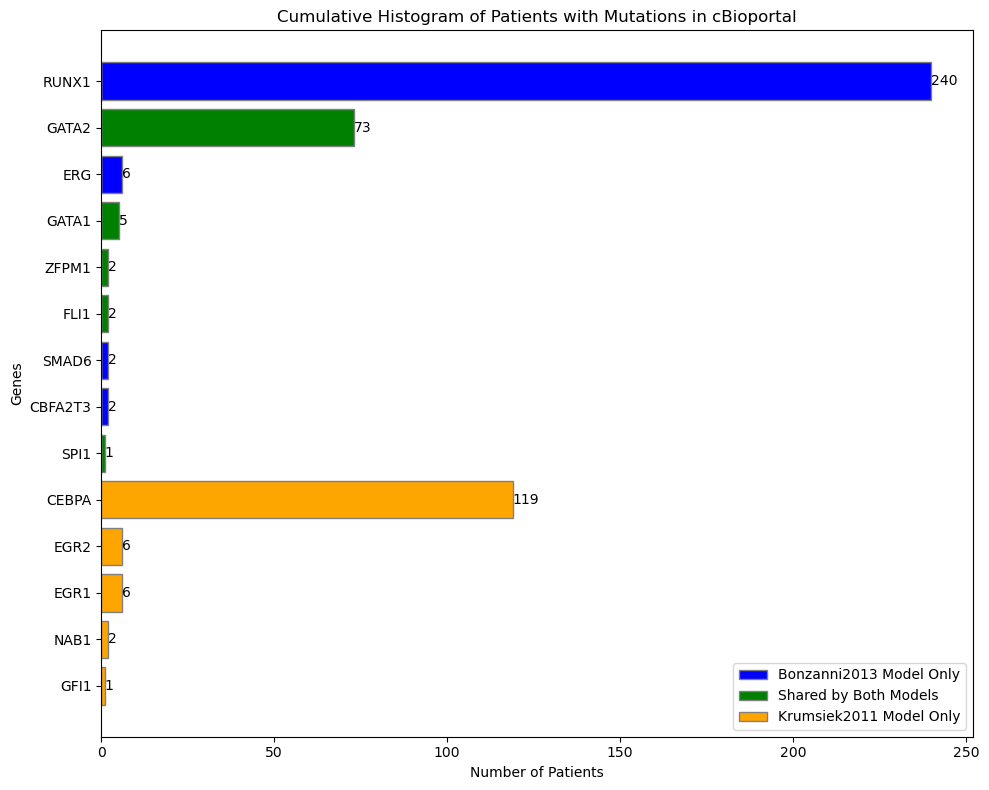

In [12]:
# Calculate the unique and shared patients
patient_counts_df_c['Shared'] = np.minimum(patient_counts_df_c[model1], patient_counts_df_c[model2])
patient_counts_df_c['Model1 Only'] = patient_counts_df_c[model1] - patient_counts_df_c['Shared']
patient_counts_df_c['Model2 Only'] = patient_counts_df_c[model2] - patient_counts_df_c['Shared']

# Sort the DataFrame based on the total patients for better visualization
patient_counts_df_c = patient_counts_df_c.sort_values(by=[model1, model2], ascending=True)
patient_counts_df_c = patient_counts_df_c[patient_counts_df_c.index != 'Total'] # Remove 'Total' row

plt.figure(figsize=(10, 8))
bars_1 = plt.barh(patient_counts_df_c.index, patient_counts_df_c['Model1 Only'], color='blue', edgecolor='gray', label=model1+' Model Only')
bars_shared = plt.barh(patient_counts_df_c.index, patient_counts_df_c['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(patient_counts_df_c.index, patient_counts_df_c['Model2 Only'], color='orange', edgecolor='gray', label=model2+' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Cumulative Histogram of Patients with Mutations in cBioportal')
plt.yticks(ticks=np.arange(len(patient_counts_df_c)), labels=patient_counts_df_c.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(patient_counts_df_c['Model2 Only'].sum())))
plt.show()

# Combined three datasets

In [146]:
# BeatAML + TCGA-LAML + AMLSG
pd.concat([patient_counts_df, patient_counts_df_tcga, patient_counts_df_p],axis=1).to_csv("counts_"+model1+'-'+model2+".csv")

Total Increased Coverage:28


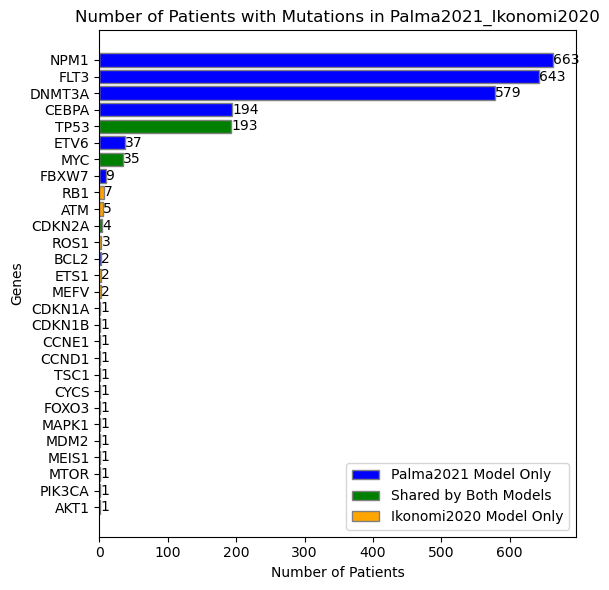

In [140]:
combined_df = pd.concat([patient_counts_df, patient_counts_df_tcga, patient_counts_df_p]).groupby(level=0).sum()
combined_df['Shared'] = np.minimum(combined_df[model1], combined_df[model2])
combined_df['Model1 Only'] = combined_df[model1] - combined_df['Shared']
combined_df['Model2 Only'] = combined_df[model2] - combined_df['Shared']

# Sort the DataFrame 
combined_df = combined_df.sort_values(by=['Merged Model'], ascending=True)

# Create the cumulative histogram
plt.figure(figsize=(6, 6))
bars_1 = plt.barh(combined_df.index, combined_df['Model1 Only'], color='blue', edgecolor='gray', label=model1+' Model Only')
bars_shared = plt.barh(combined_df.index, combined_df['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(combined_df.index, combined_df['Model2 Only'], color='orange', edgecolor='gray', label=model2+' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Number of Patients with Mutations in '+ model1 +'_'+ model2)
plt.yticks(ticks=np.arange(len(combined_df)), labels=combined_df.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(combined_df['Model2 Only'].sum())))
plt.show()

In [164]:
# cBioportal + AMLSG
pd.concat([patient_counts_df_c, patient_counts_df_p],axis=1).to_csv("counts_c_"+model1+'-'+model2+".csv")

Total Increased Coverage:270


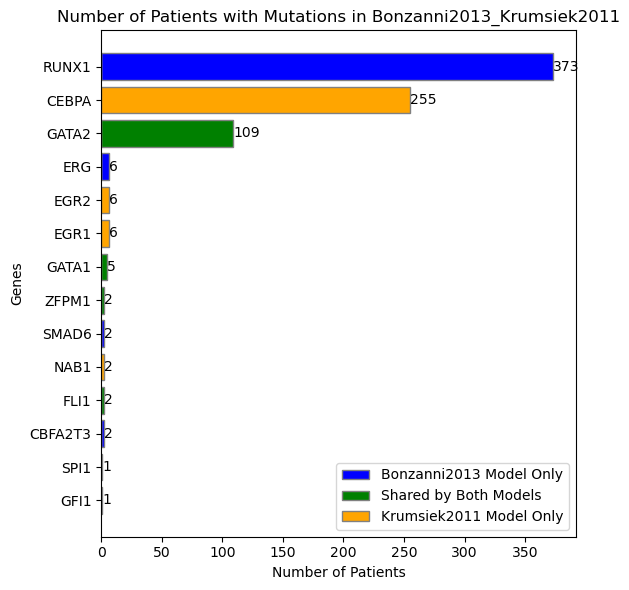

In [163]:
combined_df = pd.concat([patient_counts_df_c, patient_counts_df_p]).groupby(level=0).sum()
combined_df['Shared'] = np.minimum(combined_df[model1], combined_df[model2])
combined_df['Model1 Only'] = combined_df[model1] - combined_df['Shared']
combined_df['Model2 Only'] = combined_df[model2] - combined_df['Shared']

# Sort the DataFrame 
combined_df = combined_df.sort_values(by=['Merged Model'], ascending=True)

# Create the cumulative histogram
plt.figure(figsize=(6, 6))
bars_1 = plt.barh(combined_df.index, combined_df['Model1 Only'], color='blue', edgecolor='gray', label=model1+' Model Only')
bars_shared = plt.barh(combined_df.index, combined_df['Shared'], color='green', edgecolor='gray', label='Shared by Both Models')
bars_2 = plt.barh(combined_df.index, combined_df['Model2 Only'], color='orange', edgecolor='gray', label=model2+' Model Only')

# Annotate the number of patients
for bars in [bars_1, bars_shared, bars_2]:
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width + bar.get_x(), bar.get_y() + bar.get_height()/2,
                     f'{int(width)}', ha='left', va='center')
plt.xlabel('Number of Patients')
plt.ylabel('Genes')
plt.title('Number of Patients with Mutations in '+ model1 +'_'+ model2)
plt.yticks(ticks=np.arange(len(combined_df)), labels=combined_df.index, rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
print('Total Increased Coverage:' + str(int(combined_df['Model2 Only'].sum())))
plt.show()